In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import hamiltonians as H
import utils
from scipy.linalg import eigh

%matplotlib inline

#### Setup

In [21]:
# use nvidia gpu if available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# only float32 tested
dtype = torch.double
    
print("Device:", device)
print("Data type:", dtype)

Device: cuda
Data type: torch.float64


#### build hamiltonian

In [22]:
# Hamiltonian Setup
N=1000
N_proj=20
g = 1
alpha=20

In [4]:
%time Hgen = H.H_ring_2particles(N, g, device, dtype)

CPU times: user 1.38 s, sys: 570 ms, total: 1.95 s
Wall time: 1.95 s


#### Get eigenvalues

In [5]:
%time eigs_t = torch.symeig(Hgen.type(torch.float64), eigenvectors=False).eigenvalues[:N_proj].cpu().numpy()
print(eigs_t)

CPU times: user 1.08 s, sys: 283 ms, total: 1.36 s
Wall time: 837 ms
[9.22048700e-01 3.94784176e+01 4.14505793e+01 1.57913670e+02
 1.59906583e+02 3.55305758e+02 3.57302697e+02 6.31654682e+02
 6.33653043e+02 9.86960440e+02 9.88959463e+02 1.42122303e+03
 1.42322242e+03 1.93444246e+03 1.93644206e+03 2.52661873e+03
 2.52861847e+03 3.19775183e+03 3.19975166e+03 3.94784176e+03]


In [6]:
%time eigs_sp = eigh(Hgen.type(torch.float64).cpu().numpy())[0][:N_proj]
print(eigs_sp)

CPU times: user 2.54 s, sys: 10.8 ms, total: 2.55 s
Wall time: 257 ms
[9.22048700e-01 3.94784176e+01 4.14505793e+01 1.57913670e+02
 1.59906583e+02 3.55305758e+02 3.57302697e+02 6.31654682e+02
 6.33653043e+02 9.86960440e+02 9.88959463e+02 1.42122303e+03
 1.42322242e+03 1.93444246e+03 1.93644206e+03 2.52661873e+03
 2.52861847e+03 3.19775183e+03 3.19975166e+03 3.94784176e+03]


In [7]:
# the hamiltonian model
model = utils.Hamiltonian(Hgen, N, N_proj).type(dtype)
model.to(device);

In [8]:
print(model.eye.type())

torch.cuda.DoubleTensor


In [9]:
# loss function and optimizer
criterion = utils.Cost(N_proj, alpha).type(dtype).to(device)
optimizer = utils.optim.Rprop(model.parameters(), lr=0.1)

In [10]:
# optimization
n_iter=20000
n_print=500
its, errs, hps, ips, ts = utils.optimize(model, optimizer, criterion, n_iter, n_print, stop_early=False, rel_tol=0.000001, patience=3, show_progress=True)

[1] loss: 2537535463.36545372. diff: 0.00000000. time: 0.0084
[501] loss: 893802779.05254078. diff: -16437326843.12912941. time: 1.0909
[1001] loss: 0.97603111. diff: -8938027780.76509666. time: 2.3354
[1501] loss: 0.97589842. diff: -0.00132694. time: 3.4944
[2001] loss: 0.97586845. diff: -0.00029968. time: 4.6508
[2501] loss: 0.97584470. diff: -0.00023748. time: 5.7954
[3001] loss: 0.97582967. diff: -0.00015037. time: 6.9463
[3501] loss: 0.97582312. diff: -0.00006551. time: 8.0938
[4001] loss: 0.97582062. diff: -0.00002494. time: 9.2359
[4501] loss: 0.97581963. diff: -0.00000992. time: 10.3957
[5001] loss: 0.97581910. diff: -0.00000527. time: 11.5461
[5501] loss: 0.97581872. diff: -0.00000382. time: 12.6948
[6001] loss: 0.97581842. diff: -0.00000300. time: 13.8455
[6501] loss: 0.97581820. diff: -0.00000222. time: 14.9981
[7001] loss: 0.97581802. diff: -0.00000181. time: 16.1463
[7501] loss: 0.97581787. diff: -0.00000145. time: 17.2933
[8001] loss: 0.97581774. diff: -0.00000129. time: 

In [11]:
eigs_sp

array([9.22048700e-01, 3.94784176e+01, 4.14505793e+01, 1.57913670e+02,
       1.59906583e+02, 3.55305758e+02, 3.57302697e+02, 6.31654682e+02,
       6.33653043e+02, 9.86960440e+02, 9.88959463e+02, 1.42122303e+03,
       1.42322242e+03, 1.93444246e+03, 1.93644206e+03, 2.52661873e+03,
       2.52861847e+03, 3.19775183e+03, 3.19975166e+03, 3.94784176e+03])

In [12]:
eigs_t

array([9.22048700e-01, 3.94784176e+01, 4.14505793e+01, 1.57913670e+02,
       1.59906583e+02, 3.55305758e+02, 3.57302697e+02, 6.31654682e+02,
       6.33653043e+02, 9.86960440e+02, 9.88959463e+02, 1.42122303e+03,
       1.42322242e+03, 1.93444246e+03, 1.93644206e+03, 2.52661873e+03,
       2.52861847e+03, 3.19775183e+03, 3.19975166e+03, 3.94784176e+03])

In [13]:
eigs_approx = eigh(hps[-1].cpu().detach().numpy())[0][:N_proj]
eigs_approx

array([9.22048703e-01, 3.94784176e+01, 4.14505793e+01, 1.57913670e+02,
       1.59906583e+02, 3.55305759e+02, 3.57302697e+02, 6.31657507e+02,
       6.33650209e+02, 9.87015528e+02, 9.88904262e+02, 1.42126310e+03,
       1.42318229e+03, 1.93448189e+03, 1.93640259e+03, 2.52665083e+03,
       2.52858634e+03, 3.19777335e+03, 3.19973013e+03, 3.94784176e+03])

In [14]:
def plot_rel_err(eigs, eigs_approx):
    plt.plot((eigs_approx - eigs)/eigs, 'o-')
    plt.hlines(0, 0, N_proj, linestyles='dashed')
    plt.xlabel = 'excitation number'
    plt.ylabel = 'error'

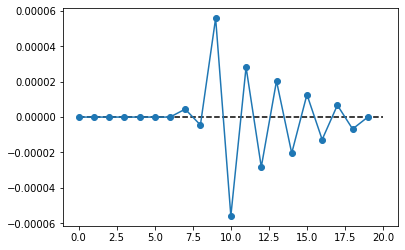

In [15]:
plot_rel_err(eigs_sp, eigs_approx)

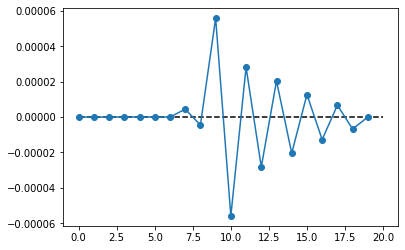

In [16]:
plot_rel_err(eigs_t, eigs_approx)

In [18]:
# # hproj progress
# vmax=np.max(eigs_sp)
# vmin=0
# for it, hp in zip(its,hps):
#     Hplt = hp.cpu().detach().numpy()
#     plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)
#     plt.title("iter: %i" % (it+1))
#     plt.colorbar()
#     plt.show()

#### Animation

In [19]:
n_iter=500
n_print=1
its, errs, hps, ips, ts = utils.optimize(model, optimizer, criterion, n_iter, n_print, stop_early=False, rel_tol=0.01, patience=3, show_progress=False)

Finished Training


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


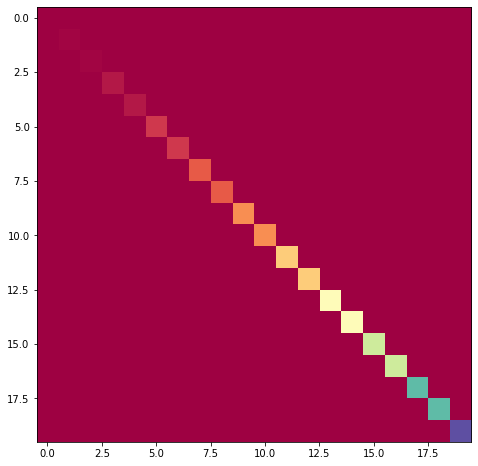

In [20]:
fig = plt.figure()
fig.set_size_inches(8,8, True)
ax = plt.axes()
vmax=np.max(eigs_sp)
vmin=0
Hplt = hps[0].cpu().detach().numpy()
mat = plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)


def init():
    mat.set_data(hps[0].cpu().detach().numpy())
    return mat,
def animate(i):
    hp = hps[i].cpu().detach().numpy()
    mat.set_data(hp)
    return mat,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(hps), interval=90, blit=True)

anim.save('diagonalization_H_ring_2particles.gif', writer='imagemagick')